# RCLIF QC and handling outliers

This script performs a quality check on the current version of your RCLIF tables and handles outliers based on the pre-determined thresholds. 
The thresholds are provided in nejm_outlier_thresholds_<table_name>.csv in this directory.

In [172]:
import sys
#!{sys.executable} -m pip3 install pandas numpy matplotlib seaborn pyarrow fuzzywuzzy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from fuzzywuzzy import fuzz
# install pyarrow to work with parquet files
import pyarrow.parquet as pq

random.seed(37)
np.random.seed(37)

print("Setup complete")

Setup complete


## User input

Provide the root locaiton of your CLIF-1.0 directory and the filetype for RCLIF data files.

In [173]:
# Enter parquet or csv only
filetype = 'parquet'
# Enter True if you want to generate graphs. The script would take 5-10 more minutes to run for all the tables
generate_graphs = True
# Enter the location for your CLIF-1.0 directory if you are not following GitHub repository structure
root_location = os.path.dirname(os.getcwd())

In [198]:
# RCLIF tables
labs_filepath = f"{root_location}/rclif/clif_labs.{filetype}"
vitals_filepath = f"{root_location}/rclif/clif_vitals.{filetype}"
encounter_filepath = f"{root_location}/rclif/clif_encounter_demographics_dispo.{filetype}"
respiratory_support_filepath = f"{root_location}/rclif/clif_respiratory_support.{filetype}"

adt_filepath = f"{root_location}/rclif/clif_adt.{filetype}"
limited_filepath = f"{root_location}/rclif/clif_limited_identifiers.{filetype}"
demog_filepath = f"{root_location}/rclif/clif_patient_demographics.{filetype}"

# directory within which table specific directories will be created to store result files
results_path = f"{root_location}/rclif_qc/"

## Common functions 

In [249]:
def read_data(filepath, filetype):
    """
    Read data from file based on file type.
    Parameters:
        filepath (str): Path to the file.
        filetype (str): Type of the file ('csv' or 'parquet').
    Returns:
        DataFrame: DataFrame containing the data.
    """
    if filetype == 'csv':
        return pd.read_csv(filepath)
    elif filetype == 'parquet':
        table = pq.read_table(filepath)
        return table.to_pandas()
    elif filetype == 'fst':
        return pd.read_fwf(filepath)
    else:
        raise ValueError("Unsupported file type. Please provide either 'csv', 'fst' or 'parquet'.")
    

def write_data(data, filepath, filetype):
    """
    Write data to file based on file type.
    Parameters:
        data (DataFrame): DataFrame containing the data to write.
        filepath (str): Path to the file.
        filetype (str): Type of the file ('csv' or 'parquet').
    Returns:
        None
    """
    if filetype == 'csv':
        data.to_csv(filepath, index=False)
    elif filetype == 'parquet':
        data.to_parquet(filepath)
    elif filetype == 'fst':
        data.to_fwf(filepath)
    else:
        raise ValueError("Unsupported file type. Please provide either 'csv', 'fst' or 'parquet'.")
    
def standardize_datetime(df):
    """
    Ensure that all *_dttm variables are in the correct format.
    Convert all datetime columns to a specific precision and remove timezone
    Parameters:
        DataFrame: DataFrame containing the data.
    Returns:
        DataFrame: DataFrame containing the data.
    """
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            # Here converting to 'datetime64[ns]' for uniformity and removing timezone with 'tz_convert(None)'
            df[col] = df[col].dt.tz_convert(None) if df[col].dt.tz is not None else df[col]
            # If you need to standardize to UTC and keep the timezone:
            # df[col] = df[col].dt.tz_localize('UTC') if df[col].dt.tz is None else df[col].dt.tz_convert('UTC')
    return df

# Define a function to find the closest match using edit distance
def find_closest_match(label, labels):
    closest_label = None
    highest_similarity = -1
    for lab_label in labels:
        similarity = fuzz.partial_ratio(label, lab_label)
        if similarity > highest_similarity:
            closest_label = lab_label
            highest_similarity = similarity
    return closest_label, highest_similarity

def check_required_variables(required_variables, df):
    """
    Check if all required variables exist in the DataFrame.
    
    Parameters:
        required_variables (list): List of required variable names.
        df (DataFrame): DataFrame to check.

    Returns:
        list: List of missing variables.
    """
    missing_variables = [var for var in required_variables if var not in df.columns]
    return missing_variables

def replace_outliers_with_na_long(df, df_outlier_thresholds, category_variable, numeric_variable):
    """
    Replace outliers in the labs DataFrame with NaNs based on outlier thresholds.

    Parameters:
        labs (DataFrame): DataFrame containing lab data.
        labs_outlier_thresholds (DataFrame): DataFrame containing outlier thresholds.

    Returns:
        DataFrame: Updated DataFrame with outliers replaced with NaNs.
        int: Count of replaced observations.
        float: Proportion of replaced observations.
    """
    replaced_count = 0
    for _, row in df_outlier_thresholds.iterrows():
        rclif_category = row[category_variable]
        lower_limit = row['lower_limit']
        upper_limit = row['upper_limit']
        # Filter DataFrame for the current category
        recorded_values = df.loc[df[category_variable] == rclif_category, numeric_variable]
        # Replace values outside the specified range with NaNs
        replaced_count += np.sum((recorded_values < lower_limit) | (recorded_values > upper_limit))
        df.loc[df[category_variable] == rclif_category, numeric_variable] = np.where((recorded_values < lower_limit) | (recorded_values > upper_limit), np.nan, recorded_values)

    total_count = len(df)
    proportion_replaced = replaced_count / total_count

    return df, replaced_count, proportion_replaced

def replace_outliers_with_na_wide(data, outlier_thresholds):
    """
    Replace outliers with NA values in a DataFrame based on specified lower and upper limits.

    Parameters:
        data (DataFrame): DataFrame containing the data.
        outlier_thresholds (DataFrame): DataFrame containing outlier thresholds.

    Returns:
        DataFrame: DataFrame with outliers replaced by NA values.
        int: Total number of observations replaced with NA.
        float: Proportion of observations replaced with NA.
    """
    # Initialize variables to record replaced observations
    total_replaced = 0

    # Iterate over each column in the DataFrame
    for col in outlier_thresholds['variable_name']:
        # Get lower and upper limits for the current column
        lower_limit = outlier_thresholds.loc[outlier_thresholds['variable_name'] == col, 'lower_limit'].values[0]
        upper_limit = outlier_thresholds.loc[outlier_thresholds['variable_name'] == col, 'upper_limit'].values[0]

        # Replace outliers with NA values
        outliers_mask = (data[col] < lower_limit) | (data[col] > upper_limit)
        total_replaced += outliers_mask.sum()
        data.loc[outliers_mask, col] = np.nan

    # Calculate proportion of replaced observations
    total_observations = data.shape[0]
    proportion_replaced = total_replaced / total_observations

    return data, total_replaced, proportion_replaced

def generate_summary_stats(data, category_column, value_column):
    """
    Generate summary statistics for a DataFrame based on a specified category column and value column.

    Parameters:
        data (DataFrame): DataFrame containing the data.
        category_column (str): Name of the column containing categories.
        value_column (str): Name of the column containing values.

    Returns:
        DataFrame: DataFrame containing summary statistics.
    """
    summary_stats = data.groupby([category_column]).agg(
        N=(value_column, 'count'),
        Missing=(value_column, lambda x: x.isnull().sum()),
        Min=(value_column, 'min'),
        Max=(value_column, 'max'),
        Mean=(value_column, 'mean'),
        Median=(value_column, 'median'),
        First_Quartile=(value_column, lambda x: x.quantile(0.25)),
        Third_Quartile=(value_column, lambda x: x.quantile(0.75))
    ).reset_index().sort_values(by=[category_column], ascending=True)

    return summary_stats

def check_categories_exist(data, outlier_thresholds, category_column):
    """
    Check if categories in outlier thresholds match with categories in the data DataFrame.

    Parameters:
        data (DataFrame): DataFrame containing the data.
        outlier_thresholds (DataFrame): DataFrame containing outlier thresholds.
        category_column (str): Name of the column containing categories.

    Returns:
        None
    """
    categories = data[category_column].unique()
    missing_categories = []

    # Iterate through outlier_thresholds DataFrame
    for _, row in outlier_thresholds.iterrows():
        category = row[category_column]
        # Check if category exists in data categories
        if category not in categories:
            # If not found, find closest match
            closest_match, similarity = find_closest_match(category, categories)
            if similarity >= 90:  # Set a threshold for similarity score
                print(f"{category} might be a close match to {closest_match}.")
            else:
                print(f"{category} doesn't exist in the categories.")
                missing_categories.append(category)

    # Check if all categories are present
    if not missing_categories:
        print("All categories exist in the DataFrame.")


def generate_facetgrid_histograms(data, category_column, value_column):
    """
    Generate histograms using seaborn's FacetGrid.

    Parameters:
        data (DataFrame): DataFrame containing the data.
        category_column (str): Name of the column containing categories.
        value_column (str): Name of the column containing values.

    Returns:
        FacetGrid: Seaborn FacetGrid object containing the generated histograms.
    """
    # Create a FacetGrid
    g = sns.FacetGrid(data, col=category_column, col_wrap=6, sharex=False, sharey=False)
    g.map(sns.histplot, value_column, bins=30, color='blue', edgecolor='black')

    # Set titles and labels
    g.set_titles('{col_name}')
    g.set_axis_labels(value_column, 'Frequency')

    # Adjust layout
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Histograms of {value_column} by {category_column}', fontsize=16)

    return g

# Define a formatting function
def non_scientific_format(x):
    return '%.2f' % x

## Table checkup

### Labs QC

The labs table must have the following variables-

* **encounter_id** 
* **lab_order_dttm** 
* **lab_collect_dttm** 
* **lab_result_dttm** 
* **lab_group** 
* **lab_category** 
* **lab_name** 
* **lab_value** 
* **reference_unit** 
* **lab_type_name** 

Optionally, you may also have a **lab_value_numeric** variable and preserve the original non-numeric lab values under **lab_value** . 
This code creates a lab_value_numeric field if it does not exist. 

In [246]:
## load labs table
labs = read_data(labs_filepath, filetype)
labs_outlier_thresholds_filepath = f"{root_location}/rclif_qc/nejm_outlier_thresholds_labs.csv"
labs_outlier_thresholds = read_data(labs_outlier_thresholds_filepath, 'csv')
os.makedirs(results_path+'labs/', exist_ok=True)

In [247]:
labs.describe()

,patient_id,encounter_id,lab_order_dttm,lab_result_dttm,lab_collect_dttm,lab_value_numeric
count,29221784.00,29221784.00,29221784,29221784,29221104,28577440.00
mean,2374242.96,15026246.91,2021-12-15 21:37:52.026651,2021-12-16 03:07:24.200939,2021-12-16 00:40:44.467897,126.60
min,6.00,18.00,2019-03-18 08:32:00,2019-03-18 10:56:00,2019-03-18 08:32:00,-1.00
25%,1154496.00,7459985.00,2021-01-06 00:15:00,2021-01-06 04:51:00,2021-01-06 02:49:00,4.00
50%,2294500.00,15078215.00,2021-12-17 16:44:00,2021-12-17 21:44:00,2021-12-17 18:13:00,11.00
75%,3636169.00,22586830.00,2022-11-25 10:43:00,2022-11-25 14:31:00,2022-11-25 12:29:00,71.00
max,4999993.00,29999988.00,2024-03-18 23:56:00,2024-03-19 00:01:00,2024-11-16 16:00:00,1002935412.00
std,1423869.67,8679704.14,NaN,NaN,NaN,265306.86


In [181]:
labs_outlier_thresholds.dtypes

lab_category    object
lower_limit      int64
upper_limit      int64
dtype: object

In [182]:
## check variables
## List of required variables
required_variables = ['encounter_id', 'lab_order_dttm', 'lab_collect_dttm', 'lab_result_dttm', 
                      'lab_group','lab_category', 'lab_name', 'lab_value', 'reference_unit', 
                      'lab_type_name']

# Check if lab_value_numeric exists, if not, create it
if 'lab_value_numeric' not in labs.columns:
    print("lab_value_numeric does not exist")
    labs['lab_value_numeric'] = pd.to_numeric(labs['lab_value'].str.extract('(\d+\.?\d*)', expand=False), errors='coerce')
    print("lab_value_numeric created")

missing_variables = check_required_variables(required_variables, labs)
if missing_variables:
    print("The following variables are missing from the labs table:")
    for var in missing_variables:
        print(f"\n- {var}")
else:
    print("All required variables exist in the labs table.")

All required variables exist in the labs table.


In [183]:
print("Checking if all lab categories are present in your RCLIF labs table:")
check_categories_exist(labs, labs_outlier_thresholds, 'lab_category')

Checking if all lab categories are present in your RCLIF labs table:
platelet count might be a close match to platelet_count.
procalcitonin doesn't exist in the categories.


In [250]:
lab_summary_stats = labs.groupby(['lab_category']).agg(
    N=('lab_value_numeric', 'count'),
    Min=('lab_value_numeric', 'min'),
    Max=('lab_value_numeric', 'max'),
    Mean=('lab_value_numeric', 'mean'),
    Median=('lab_value_numeric', 'median'),
    First_Quartile=('lab_value_numeric', lambda x: x.quantile(0.25)),
    Third_Quartile=('lab_value_numeric', lambda x: x.quantile(0.75))
).reset_index().sort_values(by=['lab_category'], ascending=False)

display(lab_summary_stats)

,lab_category,N,Min,Max,Mean,Median,First_Quartile,Third_Quartile
41,wbc,1134272,0.10,417647.00,9.80,7.60,5.30,10.90
40,troponin,184589,2.00,100000.00,198.65,31.00,13.00,85.00
39,total_protein,714364,0.20,1002797155.00,1418.93,6.80,6.00,7.30
38,sodium,1256771,0.00,79368.00,142.82,139.00,136.00,141.00
37,so2_mixed_venous,449,10.30,100.00,71.29,74.30,62.20,83.80
36,sao2,226061,0.00,2230.00,97.35,98.90,97.20,99.70
35,ptt,300717,1.00,3288786.00,71.74,38.90,30.70,64.70
34,pt,332821,0.00,69509.00,22.84,15.30,13.90,18.20
33,potassium,1508615,0.00,79368.00,7.71,4.10,3.80,4.50
32,platelet_count,1380734,0.00,417647.00,238.63,225.00,155.00,301.00


In [ ]:
output_csv_path = os.path.join(results_path,'labs/', 'labs_summary_stats.csv')
lab_summary_stats.to_csv(output_csv_path, index=False)
print(f"Summary statistics table saved to: {output_csv_path}")

In [186]:
print('Replacing outliers in the labs table with NAs. This can take a minute!')
updated_labs, replaced_count, proportion_replaced = replace_outliers_with_na_long(labs, labs_outlier_thresholds,'lab_category' , 'lab_value_numeric')
print(f"Count of replaced observations: {replaced_count}")
print(f"Proportion of replaced observations: {proportion_replaced:.2%}")

Replacing outliers in the labs table with NAs. This can take a minute!
Count of replaced observations: 960203
Proportion of replaced observations: 3.29%


In [187]:
## write the clean labs file to the rclif folder
print('Writing clean labs file')
output_filepath = f"{root_location}/rclif/clif_labs_clean.{filetype}"
write_data(updated_labs, output_filepath, filetype)
print('Clean RCLIF labs table saved to:', output_filepath)

Writing clean labs file
Clean RCLIF labs table saved to: /Users/kavenchhikara/Desktop/CLIF-1.0/rclif/clif_labs_clean.parquet


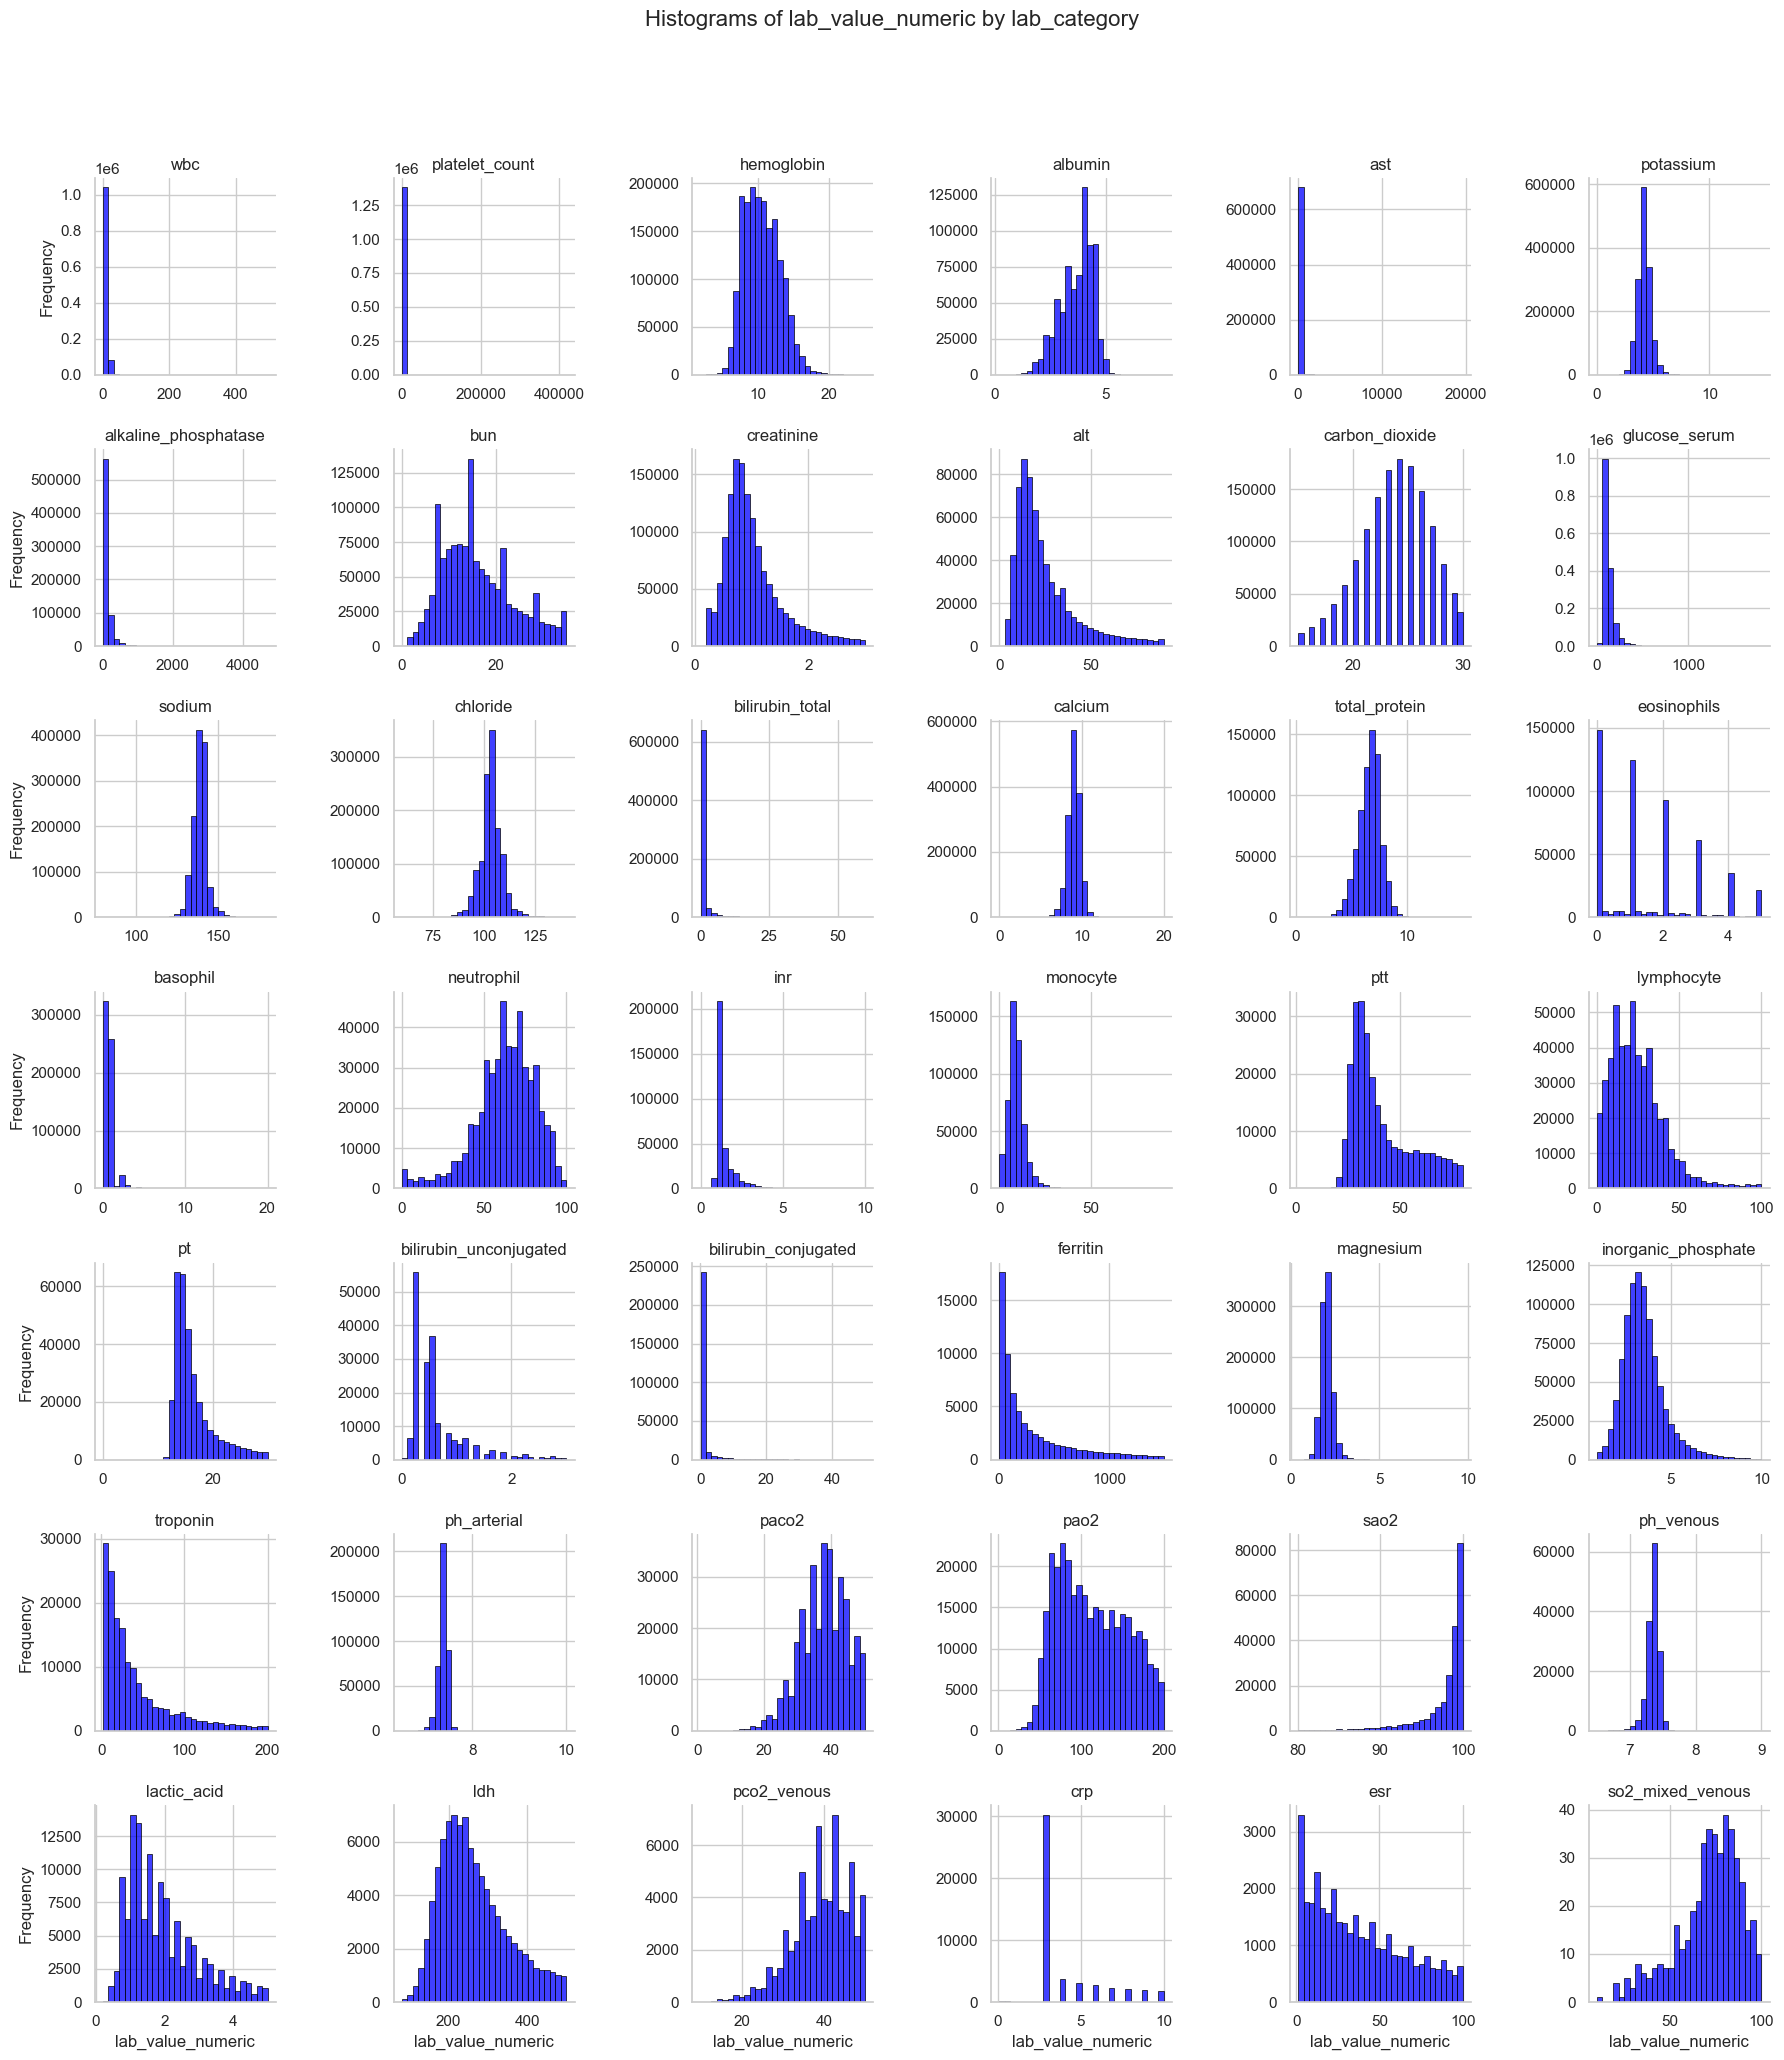

In [188]:
if generate_graphs:
    labs_plot = generate_facetgrid_histograms(updated_labs, 'lab_category', 'lab_value_numeric')
    plt.show(labs_plot)

    output_path = os.path.join(results_path, 'labs', 'labs_category_histogram.png')
    labs_plot.savefig(output_path)

In [ ]:
lab_summary_stats = generate_summary_stats(updated_labs, 'lab_category', 'lab_value_numeric')
display(lab_summary_stats)

output_csv_path = os.path.join(results_path,'labs/', 'labs_summary_stats_no_outliers.csv')
write_data(lab_summary_stats, output_csv_path, filetype)
print(f"Summary statistics without outliers saved to: {output_csv_path}")

### Vitals QC

The RCLIF vitals table must have the following variables:

* **encounter_id** 
* **recorded_dttm** 
* **vital_name**
* **vital_category** 
* **vital_value**  
* **meas_site_name** 

`vital_category` must contain the following temp_c, pulse, sbp, dbp, spo2, respiratory_rate, map, height_inches, weight_kg

In [190]:
# load vitals rclif table
vitals = read_data(vitals_filepath, filetype)
# vitals thresholds
vitals_outlier_thresholds_filepath = f"{root_location}/rclif_qc/nejm_outlier_thresholds_vitals.csv"
vitals_outlier_thresholds = read_data(vitals_outlier_thresholds_filepath, 'csv')
# create vitals results folder
os.makedirs(results_path+'vitals/', exist_ok=True)

In [191]:
## List of required variables
required_variables = ['encounter_id', 'recorded_dttm', 'vital_name', 'vital_category', 
                      'vital_value','meas_site_name']


missing_variables = check_required_variables(required_variables, vitals)
if missing_variables:
    print("The following variables are missing from the labs table:")
    for var in missing_variables:
        print(f"- {var}")
else:
    print("All required variables exist in the vitals table.")

All required variables exist in the vitals table.


In [192]:
print("Checking if all vital categories are present in your RCLIF vitals table")
check_categories_exist(vitals, vitals_outlier_thresholds, 'vital_category')

Checking if all vital categories are present in your RCLIF vitals table
All categories exist in the DataFrame.


In [193]:
vitals_summary_stats = generate_summary_stats(vitals, 'vital_category', 'vital_value')
print('Vital category distribution before outlier handling')
display(vitals_summary_stats)

Vital category distribution before outlier handling


,vital_category,N,Missing,Min,Max,Mean,Median,First_Quartile,Third_Quartile
0,dbp,14322780,0,0.000000,2.980000e+02,71.697944,71.000000,61.000000,82.000000
1,height_inches,1152840,0,1.181000,1.170000e+02,63.442449,65.510000,62.008000,69.000000
2,map,12420283,0,-511.000000,1.232122e+06,81.434091,84.000000,72.000000,96.000000
3,pulse,16274822,0,0.000000,4.000000e+02,92.978946,88.000000,75.000000,104.000000
4,respiratory_rate,15099435,0,0.000000,1.500000e+02,21.561999,18.000000,16.000000,23.000000
5,sbp,14322780,0,0.000000,3.970000e+02,123.168590,122.000000,107.000000,138.000000
6,spo2,15640988,2714,0.000000,1.000000e+02,96.853307,97.000000,95.000000,99.000000
7,temp_c,7932278,2713,0.000000,9.000000e+02,36.649976,36.611111,36.333333,36.888889
8,weight_kg,1885815,0,0.003118,1.929979e+03,74.696652,76.067378,59.420552,93.439952


In [194]:
print('Replacing outliers with NAs')
updated_vitals, replaced_count, proportion_replaced = replace_outliers_with_na_long(vitals, 
                                                                               vitals_outlier_thresholds,
                                                                               'vital_category' , 
                                                                               'vital_value')
print(f"Count of replaced observations: {replaced_count}")
print(f"Proportion of replaced observations: {proportion_replaced:.2%}")

Replacing outliers with NAs
Count of replaced observations: 642882
Proportion of replaced observations: 0.65%


In [ ]:
vital_summary_stats = generate_summary_stats(updated_vitals, 'vital_category', 'vital_value')
display(vital_summary_stats)

output_csv_path = os.path.join(results_path,'vitals/', 'vitals_summary_stats_no_outliers.csv')
write_data(vital_summary_stats, output_csv_path, filetype)
print(f"Summary statistics without outliers saved to: {output_csv_path}")

In [196]:
## write the clean labs file to the rclif folder
print('Writing final vitals dataset without outliers. This can take a minute!')
output_filepath = f"{root_location}/rclif/clif_vitals_clean.{filetype}"
write_data(updated_vitals, output_filepath, filetype)
print('Clean RCLIF vitals table saved to:', output_filepath)

Writing final vitals dataset without outliers. This can take a minute!
Clean RCLIF vitals table saved to: /Users/kavenchhikara/Desktop/CLIF-1.0/rclif/clif_vitals_clean.parquet


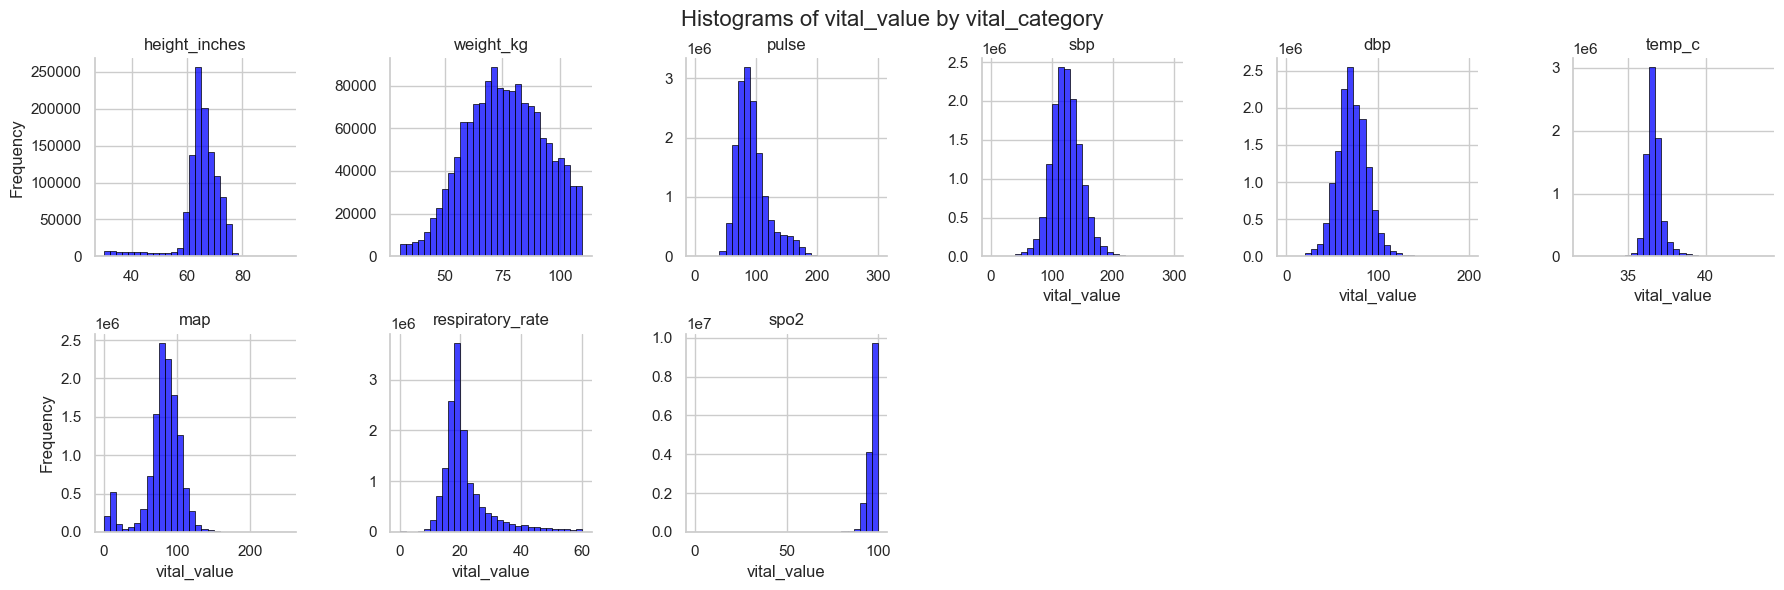

In [197]:
if generate_graphs:
    vitals_plot = generate_facetgrid_histograms(updated_vitals, 'vital_category', 'vital_value')
    plt.show(vitals_plot)
    output_path = os.path.join(results_path, 'vitals', 'vitals_category_histogram.png')
    vitals_plot.savefig(output_path)

### Encounter demographic disposition

This table must have the following variables 

* **encounter_id** 
* **age_at_admission** 
* **disposition_name** 
* **disposition_category** 

The `disposition_category` variable must have the following categories - Home, Discharged to another facility, Other, Hospice, Dead / Died, Admitted

In [239]:
encounter = read_data(encounter_filepath, filetype)
os.makedirs(results_path+'encounter_demographic_dispo/', exist_ok=True)

In [220]:
encounter['disposition_category'].unique()

array(['Home', 'Discharged to another facility', 'Other', 'Hospice',
       'Dead', 'Admitted'], dtype=object)

In [221]:
## List of required variables
required_variables = ['encounter_id', 'age_at_admission', 'disposition_name', 'disposition_category']


missing_variables = check_required_variables(required_variables, encounter)
if missing_variables:
    print("The following variables are missing from the labs table:")
    for var in missing_variables:
        print(f"- {var}")
else:
    print("All required variables exist in the vitals table.")

All required variables exist in the vitals table.


In [233]:
## Count of each vital category
encounter.groupby('disposition_category').size().reset_index(name='n').sort_values(by='n', ascending=False)

,disposition_category,n
3,Home,1353925
2,Discharged to another facility,25775
5,Other,17010
1,Dead,4586
4,Hospice,2239
0,Admitted,258


In [237]:
# Set the display option to use the formatting function
pd.options.display.float_format = non_scientific_format
encounter.describe()

,patient_id,encounter_id,age_at_admission
count,1403793.00,1403793.00,1403162.00
mean,2509008.56,15002964.68,49.68
std,1444178.23,8660666.20,22.74
min,1.00,23.00,-0.00
25%,1258910.00,7498045.00,33.00
50%,2498398.00,15000694.00,54.00
75%,3761699.00,22505216.00,67.00
max,4999994.00,29999989.00,137.00


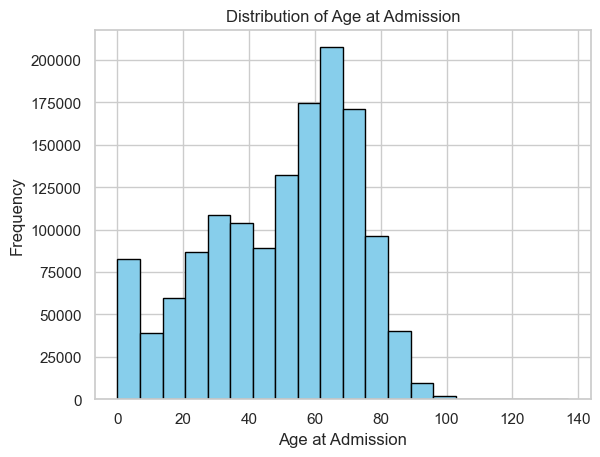

In [241]:
output_path = os.path.join(results_path, 'encounter_demographic_dispo', 'age_at_admission_histogram.png')
plt.hist(encounter['age_at_admission'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age at Admission')
plt.ylabel('Frequency')
plt.title('Distribution of Age at Admission')
plt.savefig(output_path)
plt.show()

In [243]:
encounter.loc[encounter['age_at_admission'] > 119, 'age_at_admission'] = np.nan

In [245]:
## write the clean labs file to the rclif folder
print('Writing final encounters demographic dispo dataset without outliers. This can take a minute!')
output_filepath = f"{root_location}/rclif/clif_encounter_demographics_dispo_clean.{filetype}"
write_data(updated_vitals, output_filepath, filetype)
print('Clean RCLIF  encounters demographic dispo table saved to:', output_filepath)

Writing final encounters demographic dispo dataset without outliers. This can take a minute!
Clean RCLIF  encounters demographic dispo table saved to: /Users/kavenchhikara/Desktop/CLIF-1.0/rclif/clif_encounter_demographics_dispo_clean.parquet


### Respiratory support QC

The RCLIF respiratory support table must have the following variables:

* **encounter_id** 
* **recorded_dttm** 
* **device_name** 
* **device_category** 
* **mode_name**
* **mode_category** 
* **tracheostomy**
* **lpm_set** 
* **fiO2_set** 
* **tidal_volume_set** 
* **resp_rate_set** 
* **pressure_control_set** 
* **pressure_support_set** 
* **flow_rate_set** 
* **peak_inspiratory_pressure_set** 
* **inspiratory_time_set** 
* **peep_set** 
* **tidal_volume_obs** 
* **resp_rate_obs**
* **plateau_pressure_obst** 
* **peak_inspiratory_pressure_obs** 
* **peep_obs** 
* **minute_vent_obs**

In [203]:
# load vitals rclif table
respiratory_support = read_data(respiratory_support_filepath, filetype)
# vitals thresholds
respiratory_support_outlier_thresholds_filepath = f"{root_location}/rclif_qc/nejm_outlier_thresholds_respiratory_support.csv"
respiratory_support_outlier_thresholds = read_data(respiratory_support_outlier_thresholds_filepath, 'csv')
# create vitals results folder
os.makedirs(results_path+'respiratory_support/', exist_ok=True)

In [206]:
# List of required variables
required_variables = ['encounter_id', 'recorded_dttm', 'device_name', 'device_category', 
                      'mode_name', 'mode_category', 'tracheostomy', 'lpm_set', 
                      'fio2_set', 'tidal_volume_set', 'resp_rate_set', 
                      'pressure_control_set', 'pressure_support_set', 'flow_rate_set', 
                      'peak_inspiratory_pressure_set', 'inspiratory_time_set', 
                      'peep_set', 'tidal_volume_obs', 'resp_rate_obs',
                      'plateau_pressure_obs', 'peak_inspiratory_pressure_obs', 
                      'peep_obs', 'minute_vent_obs']

# Perform the check
missing_variables = check_required_variables(required_variables, respiratory_support)

# Check if any variables are missing
if missing_variables:
    print("The following variables are missing from the respiratory_support table:")
    for var in missing_variables:
        print(f"- {var}")
else:
    print("All required variables exist in the respiratory_support table.")


All required variables exist in the respiratory_support table.


In [211]:
respiratory_summary_stats = respiratory_support.select_dtypes(include=['number','float']).describe().transpose()
display(respiratory_summary_stats)

,count,mean,std,min,25%,50%,75%,max
patient_id,6226779.0,2.540207e+06,1.454563e+06,63.0,1263712.00,2594788.00,3823371.0,4999994.0
encounter_id,6226779.0,1.500442e+07,8.666359e+06,62.0,7310780.00,15220655.00,22570981.0,29999959.0
tracheostomy,2203717.0,1.046786e-01,3.061389e-01,0.0,0.00,0.00,0.0,1.0
fio2_set,3349498.0,4.596608e-01,4.856973e+01,-1.0,0.30,0.40,0.5,88880.0
lpm_set,2265890.0,4.898253e+00,8.904048e+00,0.0,2.00,2.00,4.0,60.0
tidal_volume_set,1023931.0,3.880176e+02,9.926982e+02,-450.0,350.00,400.00,450.0,451450.0
resp_rate_set,1343769.0,2.030300e+01,1.808386e+01,-3.0,14.00,18.00,25.0,16480.0
pressure_control_set,501965.0,1.966198e+01,9.728649e+00,-30.0,15.00,20.00,22.0,1818.0
pressure_support_set,900828.0,1.214261e+01,9.191862e+00,-5.0,8.00,10.00,15.0,3837.0
flow_rate_set,380073.0,5.084877e+01,1.644531e+01,-10.0,40.70,54.00,60.0,2000.0


In [ ]:
output_csv_path = os.path.join(results_path,'respiratory_support/', 'respiratory_supports_summary_stats.csv')
respiratory_summary_stats.to_csv(output_csv_path, index=False)
print(f"Summary statistics table saved to: {output_csv_path}")

In [216]:
print('Replacing outliers with NAs')
respiratory_support_cleaned, total_replaced, proportion_replaced = replace_outliers_with_na_wide(respiratory_support, 
                                                                                                 respiratory_support_outlier_thresholds)
print(f"Total number of observations replaced with NA: {total_replaced}")
print(f"Proportion of observations replaced with NA: {proportion_replaced:.2%}")

Replacing outliers with NAs
Total number of observations replaced with NA: 194816
Proportion of observations replaced with NA: 3.13%


In [258]:
def plot_histograms_by_device_category(category_data, device_category):
    # Initialize an empty dictionary to store the plots
    plot_dict = {}

    variables_to_plot = ["fio2_set", "lpm_set", "tidal_volume_set", "resp_rate_set", 
                     "pressure_control_set", "pressure_support_set", "flow_rate_set", 
                     "peak_inspiratory_pressure_set", "inspiratory_time_set", "peep_set", 
                     "tidal_volume_obs", "resp_rate_obs", "plateau_pressure_obs", 
                     "peak_inspiratory_pressure_obs", "peep_obs", "minute_vent_obs"]
    
    # Generate a histogram for each variable
    for variable in variables_to_plot:
        if variable in category_data.columns and category_data[variable].notna().sum() > 0:
            plt.figure(figsize=(8, 6))
            sns.histplot(category_data[variable], bins=30, color="blue", edgecolor="black")
            plt.title(f"Histogram of {variable} for {device_category}")
            plt.xlabel(variable)
            plt.ylabel("Frequency")
            plt.tight_layout()
            
            # Save the plot
            file_name = f"{results_path}/respiratory_support/device_category_graphs/{device_category}_{variable}.png"
            plt.savefig(file_name)
            plt.close()
            print(f"Saved histogram of {variable} for {device_category} to {file_name}")
            plot_dict[variable] = file_name
    
    if plot_dict:
        print(f"Plots saved for {device_category}: {plot_dict}")
    else:
        print(f"No valid plots to display for {device_category}")


In [ ]:
if generate_graphs:
    os.makedirs(results_path + "respiratory_support/device_category_graphs", exist_ok=True)
    unique_device_categories = respiratory_support['device_category'].unique()
    for category in unique_device_categories:
        print(f"Creating for {category}")
        category_data = respiratory_support[respiratory_support['device_category'] == category]
        plot_histograms_by_device_category(category_data, category)